# Data preparation section

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
installed_packages = [
    "opensmile",
    "librosa",
    "google",
    "treelib",
    "graphviz",
    "tensorflow",
]

for package in installed_packages:
    !pip install {package}

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import pandas as pd
import json

In [4]:
import opensmile

smile = opensmile.Smile(
#     feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
#     feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_level=opensmile.FeatureLevel.Functionals,
)


In [5]:
import glob

try:
    files = glob.glob("../data/raw/RAVDESS/*/*.wav")
except:
    from google.colab import drive
    drive.mount('/content/gdrive')
    files = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/IP/data/RAVDESS/*/*.wav")

In [6]:
file_name_to_emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}

In [7]:
emotion_to_positivity_mapping = {
    "neutral": "positive",
    "calm": "positive",
    "happy": "positive",
    "sad": "negative",
    "angry": "negative",
    "fearful": "negative",
    "disgust": "negative",
    "surprised": "positive",
}

In [8]:
SEED = 42

##### Data reading and normalisation

In [9]:
speech_data = smile.process_files(files)

In [10]:
normalised_speech_data=(speech_data-speech_data.mean())/speech_data.std()
normalised_speech_data.dropna(axis='columns', inplace=True)

In [11]:
emotion_labels = [file_name_to_emotion_mapping[file.split("-")[-5]] for file in files]

##### Splitting the data into training, validation and test sets

In [12]:
from sklearn.model_selection import train_test_split

speeches = normalised_speech_data
emotions = emotion_labels

speeches_train_and_val, speeches_test, emotions_train_and_val, emotions_test = train_test_split(speeches, emotions, test_size=0.2, random_state=SEED, stratify=emotions)
speeches_train, speeches_val, emotions_train, emotions_val = train_test_split(speeches_train_and_val, emotions_train_and_val, test_size=0.25, random_state=SEED, stratify=emotions_train_and_val)

In [13]:
emotion_to_number_mapping = {emotion: int(number)-1 for number, emotion in file_name_to_emotion_mapping.items()}
emotions_numeric_train = np.array([emotion_to_number_mapping[emotion] for emotion in emotions_train])
emotions_numeric_val = np.array([emotion_to_number_mapping[emotion] for emotion in emotions_val])
emotions_numeric_test = np.array([emotion_to_number_mapping[emotion] for emotion in emotions_test])

In [14]:
emotions_binary_train = [emotion_to_positivity_mapping[emotion] for emotion in emotions_train]
emotions_binary_val = [emotion_to_positivity_mapping[emotion] for emotion in emotions_val]
emotions_binary_test = [emotion_to_positivity_mapping[emotion] for emotion in emotions_test]

In [15]:
# Pandas dataframes keep the old indexing after sampling, but I need it to be sequential, thus, a reset for the index
speeches_train.reset_index(drop=True, inplace=True)
speeches_val.reset_index(drop=True, inplace=True)
speeches_test.reset_index(drop=True, inplace=True)

In [16]:
from collections import Counter

print(f"{len(speeches_train)=}\t\t{len(emotions_train)=}")
print(f"{len(speeches_val)=}\t\t{len(emotions_val)=}")
print(f"{len(speeches_test)=}\t\t{len(emotions_test)=}")

print(f"{Counter(emotions_train)=}")
print(f"{Counter(emotions_val)=}")
print(f"{Counter(emotions_test)=}")

len(speeches_train)=864		len(emotions_train)=864
len(speeches_val)=288		len(emotions_val)=288
len(speeches_test)=288		len(emotions_test)=288
Counter(emotions_train)=Counter({'calm': 116, 'angry': 115, 'fearful': 115, 'sad': 115, 'happy': 115, 'surprised': 115, 'disgust': 115, 'neutral': 58})
Counter(emotions_val)=Counter({'sad': 39, 'disgust': 39, 'angry': 39, 'calm': 38, 'surprised': 38, 'fearful': 38, 'happy': 38, 'neutral': 19})
Counter(emotions_test)=Counter({'happy': 39, 'fearful': 39, 'surprised': 39, 'sad': 38, 'calm': 38, 'angry': 38, 'disgust': 38, 'neutral': 19})


# Classifier comparison section

### Building classifiers

In [17]:
from locale import Error
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

def fit_predict_and_score_classifier(classifier, data_train, data_val, labels_train, labels_val, label_set):
    classifier.fit(data_train, labels_train)
    results = {"train": {}, "val": {}}
    
    for set_type in ["train", "val"]:
        if set_type == "train":
            data = data_train
            labels = labels_train
        elif set_type == "val":
            data = data_val
            labels = labels_val
        else:
            raise Error("Undefined data set type")

        labels_predicted = classifier.predict(data)

        results[set_type]["predictions"] = labels_predicted
        results[set_type]["accuracy"] = metrics.accuracy_score(labels, labels_predicted)
        results[set_type]["precision"] = metrics.precision_score(labels, labels_predicted, average="macro", zero_division=1)
        results[set_type]["recall"] = metrics.recall_score(labels, labels_predicted, average="macro", zero_division=1)
        results[set_type]["F1"] = metrics.f1_score(labels, labels_predicted, average="macro", zero_division=1)

    return results

def create_result_table(results):
    first_key = list(results.keys())[0]
    second_key = list(results[first_key].keys())[0]
    table = pd.DataFrame(columns=["Classifier", "Set type"] + list(results[first_key][second_key].keys()))
    for classifier_name, classifier_data in results.items():
        for set_type, set_metrics in classifier_data.items():
              # Taken from (merging dicts) https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-in-python
            new_row = {"Classifier": classifier_name, "Set type": set_type} | set_metrics
            table = table.append(new_row, ignore_index=True)
    return table

# def create_result_table(results):
#     first_key = list(results.keys())[0]
#     second_key = list(results[first_key].keys())[0]
#     table = pd.DataFrame(columns=["Classifier", "Set type"] + list(results[first_key][second_key].keys()))
#     for classifier_name, classifier_data in results.items():
#         for set_type, set_metrics in classifier_data.items():
#               # Taken from (merging dicts) https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-in-python
#             new_row = pd.DataFrame({"Classifier": classifier_name, "Set type": set_type} | set_metrics)
#             table = pd.concat([table, new_row], ignore_index=True)
#     return table

def calculate_f1_scores_by_class(labels_predicted, labels):
    all_labels = sorted(list(set(labels)))
    matrix_dimension = range(len(set(labels)))
    matrix = metrics.confusion_matrix(labels, labels_predicted, labels=all_labels)

    recalls = [matrix[index, index] / row_sum for index, row_sum in enumerate(np.sum(matrix, axis=1))]
    precisions = [matrix[index, index] / column_sum for index, column_sum in enumerate(np.sum(matrix, axis=0))]

    f1_scores = {label: {} for label in all_labels}
    for index, label in enumerate(all_labels):
        f1_scores[label] = 2 * (precisions[index] * recalls[index]) / (precisions[index] + recalls[index])

    return f1_scores

In [18]:
# These parameters are repeated, so they are unwrapped while calling functions to reduce clutter
multi_class_parameters = (speeches_train, speeches_val, emotions_train, emotions_val, set(emotions))
binary_parameters = (speeches_train, speeches_val, emotions_binary_train, emotions_binary_val, set(["positive", "negative"]))
initial_classifier_results = {}
initial_classifier_results_binary = {}

In [19]:
dummy_classifier_most_frequent = DummyClassifier(strategy="most_frequent")
dummy_classifier_stratified = DummyClassifier(strategy="stratified")
logistic_regression = LogisticRegression(max_iter=1000)
svc = SVC()

### Multi-class classification

In [20]:
initial_classifier_results["dummy_classifier_most_frequent"] = fit_predict_and_score_classifier(dummy_classifier_most_frequent, *multi_class_parameters)

In [21]:
initial_classifier_results["dummy_classifier_stratified"] = fit_predict_and_score_classifier(dummy_classifier_stratified, *multi_class_parameters)

In [22]:
initial_classifier_results["logistic_regression"] = fit_predict_and_score_classifier(logistic_regression, *multi_class_parameters)

In [23]:
initial_classifier_results["svc"] = fit_predict_and_score_classifier(svc, *multi_class_parameters)

In [24]:
initial_classifier_results_table = create_result_table(initial_classifier_results)
display(initial_classifier_results_table)

C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_inde

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.134259,0.891782,0.125000,0.029592
1,dummy_classifier_most_frequent,val,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.131944,0.891493,0.125000,0.029141
2,dummy_classifier_stratified,train,"[sad, disgust, calm, fearful, fearful, sad, ne...",0.135417,0.127784,0.129207,0.127875
3,dummy_classifier_stratified,val,"[fearful, sad, happy, calm, sad, disgust, disg...",0.114583,0.113764,0.113866,0.113394
4,logistic_regression,train,"[surprised, fearful, neutral, sad, surprised, ...",0.822917,0.821884,0.819903,0.819967
5,logistic_regression,val,"[fearful, calm, surprised, sad, sad, calm, neu...",0.586806,0.560562,0.563343,0.559951
6,svc,train,"[disgust, fearful, neutral, sad, happy, surpri...",0.807870,0.812744,0.796130,0.800273
7,svc,val,"[sad, calm, fearful, sad, fearful, calm, neutr...",0.600694,0.598798,0.590081,0.587499


In [25]:
f1_scores = calculate_f1_scores_by_class(initial_classifier_results["svc"]["val"]["predictions"], emotions_val)
for emotion, score in f1_scores.items():
    print(f"{emotion}: {score}")

angry: 0.6666666666666667
calm: 0.6292134831460675
disgust: 0.6329113924050633
fearful: 0.5952380952380952
happy: 0.547945205479452
neutral: 0.43243243243243246
sad: 0.47058823529411764
surprised: 0.725


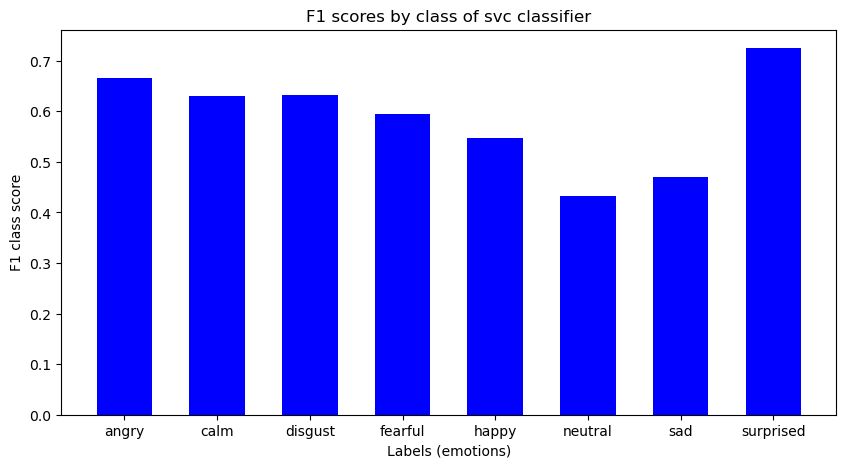

In [26]:
# Taken from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

import matplotlib.pyplot as plt

list_of_emotions = list(f1_scores.keys())
f1_score_values = list(f1_scores.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(list_of_emotions, f1_score_values, color ='blue', width = 0.6)
plt.xlabel("Labels (emotions)")
plt.ylabel("F1 class score")
plt.title("F1 scores by class of svc classifier")
plt.show()

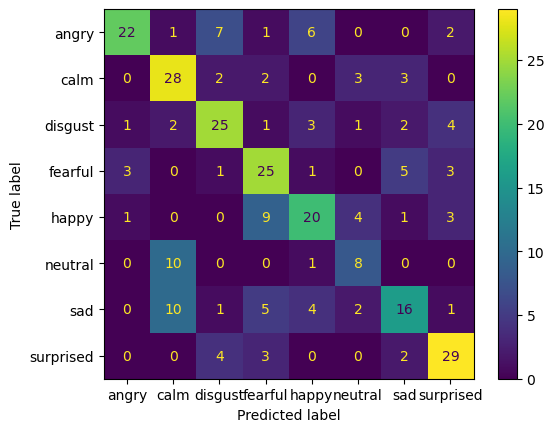

In [27]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(emotions_val, initial_classifier_results["svc"]["val"]["predictions"])
plt.show()

### Binary classification

In [28]:
initial_classifier_results_binary["dummy_classifier_most_frequent"] = fit_predict_and_score_classifier(dummy_classifier_most_frequent, *binary_parameters)

In [29]:
initial_classifier_results_binary["dummy_classifier_stratified"] = fit_predict_and_score_classifier(dummy_classifier_stratified, *binary_parameters)

In [30]:
initial_classifier_results_binary["logistic_regression"] = fit_predict_and_score_classifier(logistic_regression, *binary_parameters)

In [31]:
initial_classifier_results_binary["svc"] = fit_predict_and_score_classifier(svc, *binary_parameters)

In [32]:
initial_classifier_results_table_binary = create_result_table(initial_classifier_results_binary)
display(initial_classifier_results_table_binary)

C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_inde

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[negative, negative, negative, negative, negat...",0.532407,0.766204,0.500000,0.347432
1,dummy_classifier_most_frequent,val,"[negative, negative, negative, negative, negat...",0.538194,0.769097,0.500000,0.349887
2,dummy_classifier_stratified,train,"[positive, positive, positive, negative, negat...",0.520833,0.519660,0.519716,0.519587
3,dummy_classifier_stratified,val,"[negative, positive, positive, negative, posit...",0.454861,0.448564,0.449260,0.448471
4,logistic_regression,train,"[negative, negative, positive, negative, posit...",0.783565,0.782636,0.782878,0.782747
5,logistic_regression,val,"[negative, positive, negative, negative, negat...",0.718750,0.717145,0.717366,0.717247
6,svc,train,"[negative, negative, positive, negative, posit...",0.898148,0.898986,0.896513,0.897436
7,svc,val,"[negative, positive, negative, negative, negat...",0.770833,0.771663,0.766287,0.767594


In [33]:
f1_scores_binary = calculate_f1_scores_by_class(initial_classifier_results_binary["logistic_regression"]["val"]["predictions"], emotions_binary_val)
for emotion, score in f1_scores_binary.items():
    print(f"{emotion}: {score}")

negative: 0.7378640776699029
positive: 0.6966292134831462


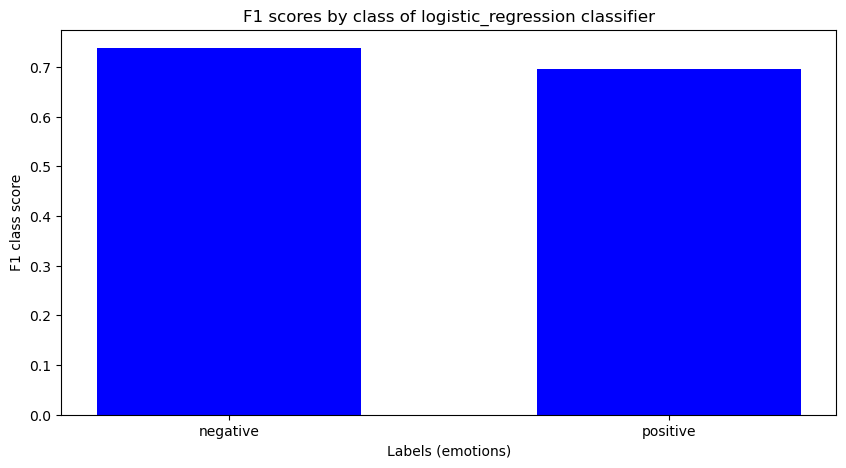

In [34]:
# Taken from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

import matplotlib.pyplot as plt

list_of_emotions_binary = list(f1_scores_binary.keys())
f1_score_values_binary = list(f1_scores_binary.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(list_of_emotions_binary, f1_score_values_binary, color ='blue', width = 0.6)
plt.xlabel("Labels (emotions)")
plt.ylabel("F1 class score")
plt.title("F1 scores by class of logistic_regression classifier")
plt.show()

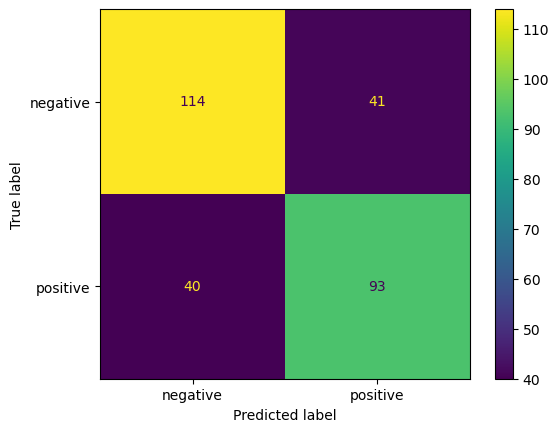

In [35]:
metrics.ConfusionMatrixDisplay.from_predictions(emotions_binary_val, initial_classifier_results_binary["logistic_regression"]["val"]["predictions"])
plt.show()

### Feature visualisation

In [36]:
# !jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [37]:
import treelib

def add_node(tree, feature, is_feature):
    feature_parent, delimiter, feature_name = feature.rpartition("_")
    
    if not tree.contains(feature_parent):
        add_node(tree, feature_parent, False)
    
    try:
        tree.create_node(tag=feature_name, identifier=feature, parent=feature_parent, data=is_feature)
    except treelib.exceptions.DuplicatedNodeIdError as error:
        # Such node already exists, potentially because recursive parent creation created it before reaching the node itself
        if is_feature:
            feature_tree.get_node(feature).data = True

feature_tree = treelib.Tree()

feature_tree.create_node(tag="ROOT", identifier="", data=False)

for column in speeches_train.columns:
    add_node(feature_tree, column, True)

In [38]:
# Taken from https://medium.com/dive-into-ml-ai/tree-data-visualization-with-treelib-71633f6fd8fb
import subprocess

feature_tree.to_graphviz("Feature hierarchy graph description.dot")
subprocess.call(["dot", "-Tsvg", "hello.dot", "-o", "Feature hierarchy graph.svg"])

2

In [39]:
# feature_tree.all_nodes()

In [40]:
feature_endings = []
analysis_by_endings = {}

for column in speeches_train.columns:
    feature_parent, delimiter, ending = column.rpartition("_")
    feature_endings.append(ending)
    
    if ending not in analysis_by_endings.keys():
        analysis_by_endings[ending] = {"features": []}
    
    analysis_by_endings[ending]["features"].append(column)
    
print(Counter(feature_endings))

Counter({'amean': 35, 'stddevNorm': 30, 'percentile20.0': 2, 'percentile50.0': 2, 'percentile80.0': 2, 'pctlrange0-2': 2, 'meanRisingSlope': 2, 'stddevRisingSlope': 2, 'meanFallingSlope': 2, 'stddevFallingSlope': 2, 'loudnessPeaksPerSec': 1, 'VoicedSegmentsPerSec': 1, 'MeanVoicedSegmentLengthSec': 1, 'StddevVoicedSegmentLengthSec': 1, 'MeanUnvoicedSegmentLength': 1, 'StddevUnvoicedSegmentLength': 1, 'dBp': 1})


### Feature optimisation section

In [41]:
classifier_for_feature_optimisation = svc
baseline_f1_score = initial_classifier_results["svc"]["val"]["F1"]

features_used_for_testing = 10_000 # 50 # 600

speeches_train_copy = speeches_train.copy()
speeches_train_copy.drop(speeches_train.columns[features_used_for_testing:], axis=1, inplace=True)
speeches_val_copy = speeches_val.copy()
speeches_val_copy.drop(speeches_val.columns[features_used_for_testing:], axis=1, inplace=True)

In [42]:
# ### Separated model to reduce time demands

# from ipywidgets import IntProgress

# # raise Exception("Prevent this cell from running so that it doesn't get stuck")

# endings_progress_bar = IntProgress(
#     min=0,
#     max=len(analysis_by_endings.keys())-1,
#     description = f"0/{len(analysis_by_endings)-1} ending"
# )

# progress_bar = IntProgress(
#     min=0,
#     max=len(speeches_train_copy.columns)-1,
#     description = f"0th feature"
# )

# inner_progress_bar = IntProgress(
#     min=0,
#     max=len(speeches_train.columns)-1,
#     description = f"0/{len(speeches_train_copy.columns)-1}"
# )

# display(endings_progress_bar)
# display(progress_bar)
# display(inner_progress_bar)

# for ending_index, data in enumerate(list(analysis_by_endings.values())):
#     data["final_data_frame"] = pd.DataFrame()
#     data["removed_features"] = []

#     speeches_train_copy = speeches_train.copy()[data["features"]]
#     speeches_val_copy = speeches_val.copy()[data["features"]]
    
#     progress_bar.value = 0
#     progress_bar.max = len(speeches_train_copy.columns)-1
#     inner_progress_bar.value = 0
#     inner_progress_bar.max = len(speeches_train_copy.columns)-1
#     endings_progress_bar.description = f"{ending_index}/{len(analysis_by_endings)-1} ending"
    
#     for feature_index in range(len(speeches_train_copy.columns)-1): # -1 so that the last feature is not deleted and an empty DataFrame is passed
#         progress_bar.description = f"{feature_index}/{len(speeches_train_copy.columns)-1} feature"

#         # Setting the new baseline
#         result = fit_predict_and_score_classifier(
#                 classifier_for_feature_optimisation,
#                 speeches_train_copy,
#                 speeches_val_copy, # speeches_val,
#                 emotions_train,
#                 emotions_val,
#                 set(emotions)
#             )
#         max_f1_score = result["val"]["F1"]
#         column_to_remove = None

#         # Finding the worst F1-reducing feature
#         inner_progress_bar.max = len(speeches_train_copy.columns)
#         inner_progress_bar.value = 0

#         for index, column in enumerate(speeches_train_copy.columns):
#             inner_progress_bar.description = f"{index}/{len(speeches_train_copy.columns)-1}"

#             result = fit_predict_and_score_classifier(
#                 classifier_for_feature_optimisation,
#                 speeches_train_copy.drop([column], axis=1),
#                 speeches_val_copy.drop([column], axis=1), # speeches_val.drop([column], axis=1),
#                 emotions_train,
#                 emotions_val,
#                 set(emotions)
#             )
#             f1_score = result["val"]["F1"]

#             if f1_score > max_f1_score:
#                 max_f1_score = f1_score
#                 column_to_remove = column

#             inner_progress_bar.value += 1

#         # Removing the worst feature
#         if column_to_remove is not None:
#             speeches_train_copy.drop([column_to_remove], axis=1, inplace=True)
#             speeches_val_copy.drop([column_to_remove], axis=1, inplace=True) # speeches_val.drop([column_to_remove], axis=1, inplace=True)
#             data["removed_features"].append((column_to_remove, max_f1_score, max_f1_score - f1_score))
#             progress_bar.value += 1
#         else:
#             progress_bar.value = progress_bar.max
#             inner_progress_bar.value = inner_progress_bar.max
#             data["final_data_frame"] = speeches_train_copy.copy()
#             break
            
#     endings_progress_bar.value += 1

In [43]:
### Full version (slow but checking everything)

from ipywidgets import IntProgress

# raise Exception("Prevent this cell from running so that it doesn't get stuck")

progress_bar = IntProgress(
    min=0,
    max=len(speeches_train_copy.columns)-1,
    description = f"0th feature"
)

inner_progress_bar = IntProgress(
    min=0,
    max=len(speeches_train.columns)-1,
    description = f"0/{len(speeches_train_copy.columns)-1}"
)

display(progress_bar)
display(inner_progress_bar)

data = []
final_data_frame = None
# data["final_data_frame"] = pd.DataFrame()
# data["removed_features"] = []

speeches_train_copy = speeches_train.copy()
speeches_val_copy = speeches_val.copy()

progress_bar.value = 0
progress_bar.max = len(speeches_train_copy.columns)-1
inner_progress_bar.value = 0
inner_progress_bar.max = len(speeches_train_copy.columns)-1

for feature_index in range(len(speeches_train_copy.columns)-1): # -1 so that the last feature is not deleted and an empty DataFrame is passed
    progress_bar.description = f"{feature_index}/{len(speeches_train_copy.columns)-1} feature"

    # Setting the new baseline
    result = fit_predict_and_score_classifier(
            classifier_for_feature_optimisation,
            speeches_train_copy,
            speeches_val_copy, # speeches_val,
            emotions_train,
            emotions_val,
            set(emotions)
        )
    max_f1_score = result["val"]["F1"]
    column_to_remove = None

    # Finding the worst F1-reducing feature
    inner_progress_bar.max = len(speeches_train_copy.columns)
    inner_progress_bar.value = 0

    for index, column in enumerate(speeches_train_copy.columns):
        inner_progress_bar.description = f"{index}/{len(speeches_train_copy.columns)-1}"

        result = fit_predict_and_score_classifier(
            classifier_for_feature_optimisation,
            speeches_train_copy.drop([column], axis=1),
            speeches_val_copy.drop([column], axis=1), # speeches_val.drop([column], axis=1),
            emotions_train,
            emotions_val,
            set(emotions)
        )
        f1_score = result["val"]["F1"]

        if f1_score > max_f1_score:
            max_f1_score = f1_score
            column_to_remove = column

        inner_progress_bar.value += 1

    # Removing the worst feature
    if column_to_remove is not None:
        speeches_train_copy.drop([column_to_remove], axis=1, inplace=True)
        speeches_val_copy.drop([column_to_remove], axis=1, inplace=True) # speeches_val.drop([column_to_remove], axis=1, inplace=True)
        data.append((column_to_remove, max_f1_score, max_f1_score - f1_score))
        progress_bar.value += 1
    else:
        progress_bar.value = progress_bar.max
        inner_progress_bar.value = inner_progress_bar.max
        final_data_frame = speeches_train_copy.copy()
        break

IntProgress(value=0, description='0th feature', max=87)

IntProgress(value=0, description='0/87', max=87)

In [44]:
data

[('loudnessPeaksPerSec', 0.5981019114807251, 0.013570592845255192),
 ('spectralFluxUV_sma3nz_amean', 0.6052547876301853, 0.010610786491682345),
 ('F3frequency_sma3nz_stddevNorm', 0.6094240586503537, 0.013944167167477595),
 ('F2bandwidth_sma3nz_stddevNorm', 0.6131144675465151, 0.011823946080952275),
 ('mfcc3V_sma3nz_stddevNorm', 0.6167998667998669, 0.010631189300528643),
 ('mfcc1_sma3_stddevNorm', 0.6202950130765496, 0.017246746036009064)]

In [45]:
removed_columns = [entry[0] for entry in data]
speeches_train_pruned = speeches_train.copy().drop(removed_columns, axis=1)
speeches_val_pruned = speeches_val.copy().drop(removed_columns, axis=1)
speeches_test_pruned = speeches_test.copy().drop(removed_columns, axis=1)

multi_class_pruned_parameters = (speeches_train_pruned, speeches_val_pruned, emotions_train, emotions_val, set(emotions))

In [46]:
print(len(speeches_train.columns), len(speeches_train_pruned.columns))

88 82


In [47]:
initial_classifier_results["svc_pruned"] = fit_predict_and_score_classifier(svc, *multi_class_parameters)

In [48]:
post_prunation_classifier_results_table = create_result_table(initial_classifier_results)
display(post_prunation_classifier_results_table)

C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_inde

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.134259,0.891782,0.125000,0.029592
1,dummy_classifier_most_frequent,val,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.131944,0.891493,0.125000,0.029141
2,dummy_classifier_stratified,train,"[sad, disgust, calm, fearful, fearful, sad, ne...",0.135417,0.127784,0.129207,0.127875
3,dummy_classifier_stratified,val,"[fearful, sad, happy, calm, sad, disgust, disg...",0.114583,0.113764,0.113866,0.113394
4,logistic_regression,train,"[surprised, fearful, neutral, sad, surprised, ...",0.822917,0.821884,0.819903,0.819967
5,logistic_regression,val,"[fearful, calm, surprised, sad, sad, calm, neu...",0.586806,0.560562,0.563343,0.559951
6,svc,train,"[disgust, fearful, neutral, sad, happy, surpri...",0.807870,0.812744,0.796130,0.800273
7,svc,val,"[sad, calm, fearful, sad, fearful, calm, neutr...",0.600694,0.598798,0.590081,0.587499
8,svc_pruned,train,"[disgust, fearful, neutral, sad, happy, surpri...",0.807870,0.812744,0.796130,0.800273
9,svc_pruned,val,"[sad, calm, fearful, sad, fearful, calm, neutr...",0.600694,0.598798,0.590081,0.587499


### Hyperparameter optimisation

In [49]:
from sklearn.model_selection import GridSearchCV

svc_parameters = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 1, 5, 10, 20, 50],
    "gamma": ["scale", "auto"],
    "shrinking": [True, False],
#     "max_iter": [-1, 100, 10_000],
}

parametrised_svc = GridSearchCV(svc, svc_parameters)
parametrised_svc.fit(speeches_train_pruned, emotions_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 5, 10, 20, 50],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'shrinking': [True, False]})

In [50]:
parametrised_svc.cv_results_.items()

dict_items([('mean_fit_time', array([0.03177004, 0.03706698, 0.03460603, 0.03310518, 0.04495354,
       0.0445076 , 0.03979235, 0.0411767 , 0.02691822, 0.03248949,
       0.03292217, 0.0329195 , 0.04368005, 0.04405246, 0.03959894,
       0.04050679, 0.05780196, 0.09727526, 0.03148675, 0.03136702,
       0.03836169, 0.04271812, 0.03166709, 0.03037801, 0.06173682,
       0.09807987, 0.03502817, 0.03472233, 0.04738684, 0.05009522,
       0.03657103, 0.03358436, 0.11465116, 0.18017602, 0.03729239,
       0.03280678, 0.04529281, 0.04094157, 0.02537789, 0.02636042,
       0.10848389, 0.17629952, 0.03339033, 0.03359337, 0.04399991,
       0.03993583, 0.024793  , 0.02439961, 0.12141752, 0.20222487,
       0.03565693, 0.03506017, 0.05338464, 0.04091115, 0.02617407,
       0.02665291, 0.12372751, 0.21019645, 0.03484893, 0.03404565,
       0.05135264, 0.03906312, 0.02321243, 0.02418303, 0.12649665,
       0.2063252 , 0.03875418, 0.03486633, 0.04724092, 0.04211044,
       0.02463794, 0.02524099, 0

In [51]:
optimised_svc = parametrised_svc.best_estimator_
optimised_parameters = parametrised_svc.best_params_
optimised_parameters

{'C': 5, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}

In [52]:
initial_classifier_results["svc_optimised"] = fit_predict_and_score_classifier(optimised_svc, *multi_class_parameters)

In [53]:
post_optimisation_classifier_results_table = create_result_table(initial_classifier_results)
display(post_optimisation_classifier_results_table)

C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_index=True)
C:\Users\Matas\AppData\Local\Temp\ipykernel_25328\2014226108.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(new_row, ignore_inde

,Classifier,Set type,predictions,accuracy,precision,recall,F1
0,dummy_classifier_most_frequent,train,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.134259,0.891782,0.125000,0.029592
1,dummy_classifier_most_frequent,val,"[calm, calm, calm, calm, calm, calm, calm, cal...",0.131944,0.891493,0.125000,0.029141
2,dummy_classifier_stratified,train,"[sad, disgust, calm, fearful, fearful, sad, ne...",0.135417,0.127784,0.129207,0.127875
3,dummy_classifier_stratified,val,"[fearful, sad, happy, calm, sad, disgust, disg...",0.114583,0.113764,0.113866,0.113394
4,logistic_regression,train,"[surprised, fearful, neutral, sad, surprised, ...",0.822917,0.821884,0.819903,0.819967
5,logistic_regression,val,"[fearful, calm, surprised, sad, sad, calm, neu...",0.586806,0.560562,0.563343,0.559951
6,svc,train,"[disgust, fearful, neutral, sad, happy, surpri...",0.807870,0.812744,0.796130,0.800273
7,svc,val,"[sad, calm, fearful, sad, fearful, calm, neutr...",0.600694,0.598798,0.590081,0.587499
8,svc_pruned,train,"[disgust, fearful, neutral, sad, happy, surpri...",0.807870,0.812744,0.796130,0.800273
9,svc_pruned,val,"[sad, calm, fearful, sad, fearful, calm, neutr...",0.600694,0.598798,0.590081,0.587499


# Neural network section

### Spectrogram creation

In [54]:
# Taken from https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0

import librosa

def pad_2d_arrays(arrays, length):
    padded_arrays = []
    for array in arrays:
        padding = np.zeros((array.shape[0], length - array.shape[1]), )
#         print("Merging: ", array.shape, padding.shape)
        padded_array = np.concatenate((array, padding), axis=1)
#         print("Result: ", padded_array.shape)
        padded_arrays.append(padded_array)
    return np.array(padded_arrays)

def plot_mel_spectrogram(audio, sampling_rate, frameSize, hop_length, n_mels):
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sampling_rate, n_fft=frameSize, hop_length=hop_length, n_mels=n_mels)
#     db_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
#     librosa.display.specshow(db_spectrogram, sr=sampling_rate, hop_length=hop_length, x_axis="time", y_axis="mel");
#     plt.colorbar(format="%+2.0f dB")
    return spectrogram

def produce_mel_spectrograms(files, hop_length=512, frameSize=2048, n_mels=128):
    spectrograms = []
    max_length= 0
    
    for file in files:
        audio, sampling_rate = librosa.load(file)
        audio, _ = librosa.effects.trim(audio)
        spectrogram = plot_mel_spectrogram(audio, sampling_rate, hop_length, frameSize, n_mels)
        spectrograms.append(spectrogram)
        max_length = max(max_length, spectrogram.shape[1])
        
    padded_spectrograms = pad_2d_arrays(spectrograms, max_length)
    
    return padded_spectrograms

In [55]:
produce_mel_spectrograms([files[0]])

array([[[6.87795643e-09, 2.08520063e-07, 3.11235908e-07, ...,
         6.37744191e-10, 4.61402259e-08, 1.85335733e-10],
        [1.39425964e-08, 4.22699827e-07, 6.30919487e-07, ...,
         1.29279820e-09, 9.35328046e-08, 3.75701914e-10],
        [1.31659341e-08, 3.74125904e-07, 1.37876725e-07, ...,
         1.03019870e-09, 9.59307442e-08, 1.99651309e-10],
        ...,
        [1.39809248e-10, 2.01874184e-09, 1.10767062e-09, ...,
         2.47235427e-11, 2.22608529e-10, 7.33699733e-12],
        [8.61807015e-11, 2.66195621e-10, 1.03274389e-09, ...,
         8.05307470e-12, 1.38230122e-10, 1.39359418e-11],
        [1.89220497e-11, 2.40337299e-11, 3.29592777e-11, ...,
         1.94230222e-12, 6.43799597e-12, 2.38649812e-12]]])

In [ ]:
spectrograms = produce_mel_spectrograms(files)

In [ ]:
Counter([s.shape for s in spectrograms])

In [ ]:
normalised_spectrograms=(spectrograms-spectrograms.mean())/spectrograms.std()

In [ ]:
spectrograms_train_and_val, spectrograms_test, temp_train_and_val, temp_test = train_test_split(normalised_spectrograms, emotions, test_size=0.2, random_state=SEED, stratify=emotions)
spectrograms_train, spectrograms_val, temp_train, temp_val = train_test_split(spectrograms_train_and_val, temp_train_and_val, test_size=0.25, random_state=SEED, stratify=temp_train_and_val)

In [ ]:
spectrograms_train = np.expand_dims(spectrograms_train, axis=1) # <--- add channel axis
spectrograms_val = np.expand_dims(spectrograms_val, axis=1) # <--- add channel axis
spectrograms_test = np.expand_dims(spectrograms_test, axis=1) # <--- add channel axis

In [ ]:
print(np.max(spectrograms))
print(np.mean(spectrograms))

In [ ]:
spectrograms_train.shape

### Setting up DataSet and DataLoader

In [ ]:
import torch
import torch.nn.functional as F
import datetime

spectrograms_tensor_train = torch.from_numpy(spectrograms_train).float()
spectrograms_tensor_val = torch.from_numpy(spectrograms_val).float()
spectrograms_tensor_test = torch.from_numpy(spectrograms_test).float()

emotions_tensor_train = torch.from_numpy(emotions_numeric_train).long()
emotions_tensor_val = torch.from_numpy(emotions_numeric_val).long()
emotions_tensor_test = torch.from_numpy(emotions_numeric_test).long()

spectrogram_dimensions = spectrograms_tensor_train.size()[1:]

In [ ]:
spectrograms_tensor_train.size()

In [ ]:
# training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
# validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# # Create data loaders for our datasets; shuffle for training, not for validation
# training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
# validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

In [ ]:
spectrogram_dataset_train = torch.utils.data.TensorDataset(spectrograms_tensor_train, emotions_tensor_train)
spectrogram_dataset_val = torch.utils.data.TensorDataset(spectrograms_tensor_val, emotions_tensor_val)

spectrogram_loader_val = torch.utils.data.DataLoader(spectrogram_dataset_val, batch_size=4, shuffle=True)
spectrogram_loader_train = torch.utils.data.DataLoader(spectrogram_dataset_train, batch_size=4, shuffle=False)

### Multi Layered Perceptron

##### Spectrograms as input

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import models
# from tensorflow.keras import layers

# model = models.Sequential()
# model.add(layers.Flatten())
# model.add(layers.Dense(1000, activation=tf.nn.relu))
# model.add(layers.Dense(1000, activation=tf.nn.relu))
# model.add(layers.Dense(1000, activation=tf.nn.relu))
# model.add(layers.Dense(100, activation=tf.nn.relu))
# model.add(layers.Dense(30, activation=tf.nn.relu))
# model.add(layers.Dense(8, activation=tf.nn.softmax))

# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"],
# )

# model.fit(spectrograms_train, emotions_numeric_train, epochs=3)

In [ ]:
# val_loss, val_accuracy = model.evaluate(spectrograms_val, emotions_numeric_val)
# print(f"Loss: {val_loss:.4f}, accuracy: {val_accuracy:.4f}")

In [ ]:
class PerceptronSpectrogramModel(torch.nn.Module):

    def __init__(self):
        super(PerceptronSpectrogramModel, self).__init__()
        
        self.linear1 = torch.nn.Linear(np.prod(spectrogram_dimensions), 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 8)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [ ]:
model = PerceptronSpectrogramModel()
# logits = model(spectrograms_tensor_train)
# pred_probab = torch.nn.Softmax(dim=1)(logits)
# y_pred =   pred_probab.argmax(1)
# y_pred

In [ ]:
# y_pred.size()

### Convolutional Neural Network

In [ ]:
# model = models.Sequential()

# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=spectrograms_train.shape[1:]))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(layers.Flatten())
# model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(8))

In [ ]:
# model.summary()

In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# history = model.fit(spectrograms_train, emotions_numeric_train, epochs=10, 
#                     validation_data=(spectrograms_val, emotions_numeric_val))

In [ ]:
# val_loss, val_accuracy = model.evaluate(spectrograms_val, emotions_numeric_val)
# print(f"Loss: {val_loss:.4f}, accuracy: {val_accuracy:.4f}")

In [ ]:
convoluted_dimensions = np.array(spectrogram_dimensions)
print(convoluted_dimensions)
convoluted_dimensions -= (5 - 1)
convoluted_dimensions //= 2
convoluted_dimensions -= (3 - 1)
convoluted_dimensions //= 2
convoluted_dimensions[0] = 1
print(convoluted_dimensions)

In [ ]:
# class CNN(torch.nn.Module):

#     def __init__(self):
#         super(CNN, self).__init__()
#         # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
#         # kernel
#         self.conv1 = torch.nn.Conv2d(1, 6, 5)
#         self.conv2 = torch.nn.Conv2d(6, 16, 3)
#         # an affine operation: y = Wx + b
#         self.fc1 = torch.nn.Linear(16 * np.prod(convoluted_dimensions), 64)
#         self.fc2 = torch.nn.Linear(64, 24)
#         self.fc3 = torch.nn.Linear(24, 8)

#     def forward(self, x):
#         # Max pooling over a (2, 2) window
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         # If the size is a square you can only specify a single number
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = x.view(-1, self.num_flat_features(x))
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features

In [ ]:
convoluted_dimensions = np.array(spectrogram_dimensions)
print(convoluted_dimensions)
convoluted_dimensions -= (5 - 1)
convoluted_dimensions //= 2
convoluted_dimensions[0] = 1
print(convoluted_dimensions)

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(1, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16 * np.prod(convoluted_dimensions), 64)
        self.fc2 = torch.nn.Linear(64, 8)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # If the size is a square you can only specify a single number
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
model = CNN()
# logits = model(spectrograms_tensor_train[:1])
# pred_probab = torch.nn.Softmax(dim=1)(logits)
# y_pred = pred_probab.argmax(1)
# y_pred

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.parameters

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    running_accuracy = 0.
    last_accuracy = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(spectrogram_loader_train):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        output_predictions = torch.nn.Softmax(dim=1)(outputs).argmax(1)        
        accuracy = torch.sum(output_predictions == labels) / len(labels)

#         print(outputs)
#         print()
#         print(output_predictions)
#         print(labels)
#         print(accuracy)

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        running_accuracy += accuracy
        if i % 50 == 49:
            last_loss = running_loss / 50 # loss per batch
            last_accuracy = running_accuracy / 50 # accuracy per batch
#             print(f"  batch {i + 1} loss: {last_loss:.4f} acc: {last_accuracy:.4f}")
# #             tb_x = epoch_index * len(training_loader) + i + 1
# #             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            running_accuracy = 0.
        elif i == len(spectrogram_loader_train)-1:
            last_loss = running_loss / (len(spectrogram_loader_train) % 50) # loss per batch
            last_accuracy = running_accuracy / (len(spectrogram_loader_train) % 50) # accuracy per batch
#             print(f"  batch {i + 1} loss: {last_loss:.4f} acc: {last_accuracy:.4f}")
# #             tb_x = epoch_index * len(training_loader) + i + 1
# #             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            running_accuracy = 0.

    return last_loss, last_accuracy

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/cnn_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 15

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print(f"EPOCH {epoch_number + 1}:")

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, avg_accuracy = train_one_epoch(epoch_number, None) #     avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    running_vaccuracy = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(spectrogram_loader_val):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
            
            voutput_predictions = torch.nn.Softmax(dim=1)(voutputs).argmax(1)        
            vaccuracy = torch.sum(voutput_predictions == vlabels) / len(vlabels)
            running_vaccuracy += vaccuracy

    avg_vloss = running_vloss / (i + 1)
    avg_vaccuracy = running_vaccuracy / (i + 1)
    print(f"LOSS train {avg_loss:.4f} valid {avg_vloss:.4f} \t ACC train {avg_accuracy:.4f} valid {avg_vaccuracy:.4f}")

#     # Log the running loss averaged per batch
#     # for both training and validation
#     writer.add_scalars('Training vs. Validation Loss',
#                     { 'Training' : avg_loss, 'Validation' : avg_vloss },
#                     epoch_number + 1)
#     writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = "model_checkpoints/model_{timestamp}_{epoch_number}"
#         torch.save(model.state_dict(), model_path)

    epoch_number += 1

### TF website example

In [ ]:
import tensorflow as tf

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [246]:
train_images.shape

(50000, 32, 32, 3)

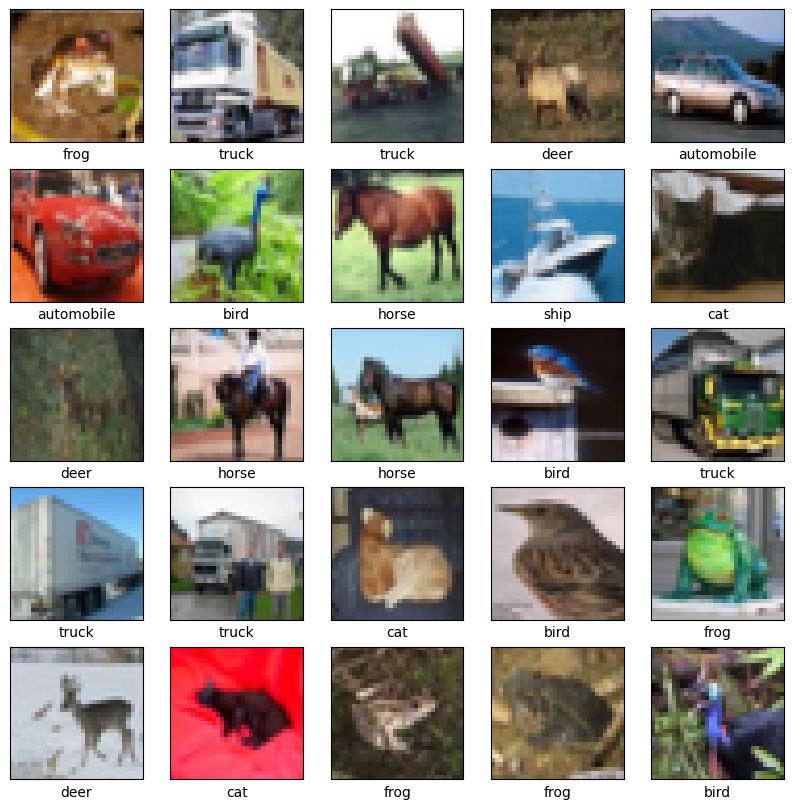

In [247]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [248]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

NameError: name 'models' is not defined

In [ ]:
model.summary()

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
print(test_acc)

In [ ]:
# import json

# # modified_analysis_by_endings = {k: {"features": v["features"], "final_data_frame": v["final_data_frame"].to_json(), "removed_features": v["removed_features"]} for k,v in analysis_by_endings}

# modified_analysis_by_endings = {}

# for k,v in analysis_by_endings.items():
# #     if "features" in v.keys():
# #         modified_analysis_by_endings[k] = v["features"]
# #     if "final_data_frame" in v.keys():
# #         modified_analysis_by_endings[k] = v["final_data_frame"].to_json()
#     if "removed_features" in v.keys():
#         modified_analysis_by_endings[k] = v["removed_features"]


# # for data in modified_analysis_by_endings.values():
# #     print(data)
# # #     data["final_data_frame"] = data["final_data_frame"].to_json()

# # print(modified_analysis_by_endings.keys())
# # print(modified_analysis_by_endings["range"])





In [ ]:
# with open('results.json', 'w') as fp:
#     json.dump(modified_analysis_by_endings, fp)

### ––––––––––––––––––––––––––

In [ ]:
# display(removed_features)

In [ ]:
# display(len(speeches_train_copy.columns))

In [ ]:
# feature_f1_comparison = {"BASELINE": initial_classifier_results["svc"]["val"]["F1"]} | {feature: [feature_result["val"]["F1"]] for feature, feature_result in feature_optimisation_results.items()}

# f1_comparison_data_frame = pd.DataFrame.from_dict(feature_f1_comparison)

# f1_comparison_data_frame.to_csv("F1 scores.csv")

# display(f1_comparison_data_frame)

### ––––––––––––––––––––––––––

In [ ]:
# all_removed_features = [removed_feature[0] for removed_list in modified_analysis_by_endings.values() for removed_feature in removed_list]
# all_removed_parents = [feature.rpartition("_")[0] for feature in all_removed_features]

In [ ]:
# Counter(all_removed_parents)

In [ ]:
# Counter(all_removed_parents).most_common(20)

##### Model with removed features

In [ ]:
# results_file_name = "results.json"

# with open(results_file_name, "r") as f:
#     results_from_json = json.load(f)

In [ ]:
# concatenated_results = []
# removed_feature_name_stems = []

# for ending_results in results_from_json.values():
#     for results_row in ending_results:
#         concatenated_results.append(results_row)
#         removed_feature_name_stems.append(results_row[0].rpartition("_")[0])
        
# # # Strings don't work in np...
# # concatenated_results = np.array([])

# # for ending_results in results_from_json.values():
# #     for results_row in ending_results:
# #         np.concatenate(concatenated_results, np.array(results_row))

In [ ]:
# Counter(removed_feature_name_stems)

In [ ]:
# min_threshold = 5
# often_removed_stems = {}

# for stem, count in Counter(removed_feature_name_stems).items():
#     if count >= min_threshold:
#         often_removed_stems[stem] = count

In [ ]:
# often_removed_stems

In [ ]:
# pruned_feature_set = []

# for feature in speeches.columns:
#     feature_stem = feature.rpartition("_")[0]
#     if feature_stem in often_removed_stems:
#         pruned_feature_set.append(feature)

In [ ]:
# # Use percentages rather than absolute values?

# print(f"Frequency threshold to prune a feature: {min_threshold}")
# print(f"Original feature count: {len(speeches.columns)}")
# print(f"Post-prunation count: {len(pruned_feature_set)}")
# print(f"Pruned features: {len(speeches.columns) - len(pruned_feature_set)}")
# print(f"Post-prunation count: {len(often_removed_stems)}")

In [ ]:
# post_prunation_results = {}
# most_frequent_removal_count = max(Counter(removed_feature_name_stems).values())

# for min_threshold in range(most_frequent_removal_count + 1):
#     often_removed_stems = {}
#     pruned_feature_set = []

#     for stem, count in Counter(removed_feature_name_stems).items():
#         if count >= min_threshold:
#             often_removed_stems[stem] = count

#     for feature in speeches.columns:
#         feature_stem = feature.rpartition("_")[0]
#         if feature_stem in often_removed_stems:
#             pruned_feature_set.append(feature)

#     multi_class_pruned_parameters = (speeches_train[pruned_feature_set], speeches_val[pruned_feature_set], emotions_train, emotions_val, set(emotions))

#     post_prunation_results[f"logistic_regression_{min_threshold}"] = fit_predict_and_score_classifier(logistic_regression, *multi_class_pruned_parameters)
#     post_prunation_results[f"svc_{min_threshold}"] = fit_predict_and_score_classifier(svc, *multi_class_pruned_parameters)

# post_prunation_results_table = create_result_table(post_prunation_results)

In [ ]:
# display(post_prunation_results_table)
# # display(post_prunation_results_table[post_prunation_results_table["Set type"]=="val"])